<a href="https://colab.research.google.com/github/armindocachada/lithopane-square-lamp/blob/master/Lithopane_of_an_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

# Upload images

In [15]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  


Saving shroud_negative_front.png to shroud_negative_front (1).png
User uploaded file "shroud_negative_front.png" with length 2848967 bytes


In [7]:
!pip3 install numpy-stl
!pip3 install bezier

In [8]:
!pip3 install pymesh

## Maths functions

In [16]:
#  The distance formula states that the distance between two points in 
# xyz-space is the square root of the sum of the squares of the differences 
# between corresponding coordinates. That is, given P1 = (x1,y1,z1) and P2 = (x2,y2,z2), 
# the distance between P1 and P2 is given by d(P1,P2) = (x2 x1)2 + (y2 y1)2 + (z2 z1)2.
import math
def distance_points(p1, p2):
    (x1,y1,z1)=p1
    (x2,y2,z2)=p2
    d =math.sqrt(math.pow(x2-x1,2) + math.pow(y2-y1,2) + math.pow(z2-z1,2))
    return d
    
def calculate_teta(startPoint, endPoint):
  (x1,y1,z1)=startPoint
  (x2,y2,z2)=endPoint
  
  AB = distance_points(startPoint, endPoint)
  AC = math.fabs(x2- x1)
  BC = math.fabs(z2-z1)
  
  print("AB={} AC={} BC={}".format(AB,AC,BC))
  if AC==0 or BC==0:
    teta = 0
  else:
    cosine_teta= (math.pow(AB,2) + math.pow(AC,2) - math.pow(BC,2))/(2*AB*AC)
    
    teta= math.acos(cosine_teta)
    
  return teta

def rotate_point_2d(point, angle):
  (px, py) = point
  x1 = px * math.cos(angle) - py * math.sin(angle)
  y1 = py * math.cos(angle) + px * math.sin(angle)
  
  return (x1,y1)
  

## Convert image to numpy array

In [17]:
import stl
import bezier
import numpy as np
from stl import mesh

def combineMeshes(meshes):
   mesh_combined = mesh.Mesh(
        np.concatenate([mesh.data for mesh in meshes]))

   return mesh_combined

def createMesh(vertices1, vertices2, resolution = 1):
    vertices = np.concatenate([vertices1, vertices2])
    vertices = vertices * (resolution, resolution, 1)
    line_size = len(vertices1)
    faces = []
    for i in range(line_size-1):
        face = (i, i + line_size, i + line_size + 1)
        faces.append(face)
        face = (i, i + 1, i + line_size + 1)
        faces.append(face)
    
    faces = np.array(faces)
    msh = mesh.Mesh(np.zeros(len(faces), dtype=mesh.Mesh.dtype))
    for i, f in enumerate(faces,0):
        for j in range(3):
            value = vertices[f[j]]
            msh.vectors[i][j] = value

    return msh

from stl import mesh

def createLMesh(vertices_lines):
    number_lines=len(vertices_lines)
    meshes = []
    for index, vertices in enumerate(vertices_lines):
      if index < number_lines-1:
           mesh = createMesh(vertices,vertices_lines[index+1])
           meshes.append(mesh)
   
    return combineMeshes(meshes)
  
def createBevelMesh(width, height, depth, resolution=1, bezierThreshold=3.0):
  bezier_size=10
  startPoint = (0,0,0)
  (start_x,start_y,start_z)=startPoint
  endPoint=(width, 0, height )
  (end_x,end_y,end_z)= endPoint
  
  # bezier curve library only supports 2d, so we have to convert this
  # to 2d
  # to do that we calculate the distance between the 2 points
  # and then translate that value to the x axis
  total_distance = distance_points(startPoint, endPoint)
  (new_end_x,new_end_y) = (start_x+total_distance, start_y)
  
  teta = calculate_teta(startPoint, endPoint)
  (control_x,control_y) = (int((start_x + new_end_x) / 2), start_y + bezierThreshold)
  
  
  nodes = np.asfortranarray([
       [start_x, control_x, new_end_x],
       [start_y, control_y, new_end_y],
  ])
  
  curve = bezier.Curve(nodes, degree=2)
  s_vals = np.linspace(0.0, 1.0, bezier_size)
  points = curve.evaluate_multi(s_vals)
  bezier_points = np.stack(points, axis=-1)
  vertices=[]
  
  #zarray = np.arange(depth+1)
  zarray = np.arange(depth * resolution +1)
  vertices_lines =[]
  for z in zarray:
    zeds = np.repeat(z,len(bezier_points))
    threed_points = np.column_stack((bezier_points,zeds))
    vertices_lines.append(threed_points)

  vertices_bottom = []
  vertices_top = []
  #create a face at both ends of the bevel
  delta_x = width / bezier_size
  print("Width: {},delta_x:{}".format(width,delta_x))
  for n in range(bezier_size):
    if n == 0:
      x = 0
    else:
      x = delta_x * (n+1)
    
    y = -height
    rotated_point = rotate_point_2d((x,y), teta)
    #rotated_point = tuple(np.multiply(rotated_point,(1,-1)))
    #rotated_point = np.negative(rotated_point)
    
    print("Rotated Point:{}".format(rotated_point))
    vertices_bottom.append(rotated_point + (0,))
    vertices_top.append(rotated_point + (depth * resolution,))
    
  vertices_lines.insert(0, vertices_bottom)
  vertices_lines.append(vertices_top)

                     
  mesh = createLMesh(vertices_lines)
  mesh.rotate((0.5,0.0,0.0), math.radians(90))
  dim=get_dimensions(mesh)
  print("size:{}".format(dim))
  mesh.rotate((0.0,0.5,0.0), math.radians(-90))
  mesh.z+=total_distance
 
  mesh.rotate((0.0,0.5,0.0), teta- math.radians(90))
  
  vertices_left_down = np.array([(0, y, 0) for y in range(0, depth)]) * (1, resolution, 1)
  vertices_right_down = np.array([(width, y, 0) for y in range(0, depth)]) * (1, resolution, 1)

  mesh_bottom = createMesh(vertices_left_down,vertices_right_down)
  
  mesh = combineMeshes([mesh_bottom, mesh])
  return mesh

def createRectangularMesh(height,width, resolution=1):
  vertices1 = [(0,0,0),(0,height-1,0)] 
  vertices2 = [(width-1,0,0),(width-1,height-1,0)]
  
  return createMesh(vertices1,vertices2, resolution)
  
  
# find the max dimensions, so we can know the bounding box, getting the height,
# width, length (because these are the step size)...
def get_dimensions(obj):
    minx = maxx = miny = maxy = minz = maxz = None
    for p in obj.points:  
        # p contains (x, y, z)
        if minx is None:
            minx = p[stl.Dimension.X]
            maxx = p[stl.Dimension.X]
            miny = p[stl.Dimension.Y]
            maxy = p[stl.Dimension.Y]
            minz = p[stl.Dimension.Z]
            maxz = p[stl.Dimension.Z]
           
        else:
            maxx = max(p[stl.Dimension.X], maxx)
            minx = min(p[stl.Dimension.X], minx)
            maxy = max(p[stl.Dimension.Y], maxy)
            miny = min(p[stl.Dimension.Y], miny)
            maxz = max(p[stl.Dimension.Z], maxz)
            minz = min(p[stl.Dimension.Z], minz)
            

            
    print("MAXZ:{}".format(maxz))
    print("MINZ:{}".format(minz))
    return (maxx-minx, maxy-miny, maxz - minz)

def get_mesh_coordinates(obj):
  minx = maxx = miny = maxy = minz = maxz = None
  for p in obj.points:  
   # p contains (x, y, z)
   if minx is None:
      minx = p[stl.Dimension.X]
      maxx = p[stl.Dimension.X]
      miny = p[stl.Dimension.Y]
      maxy = p[stl.Dimension.Y]
      minz = p[stl.Dimension.Z]
      maxz = p[stl.Dimension.Z]
   else:
      maxx = max(p[stl.Dimension.X], maxx)
      minx = min(p[stl.Dimension.X], minx)
      maxy = max(p[stl.Dimension.Y], maxy)
      miny = min(p[stl.Dimension.Y], miny)
      maxz = max(p[stl.Dimension.Z], maxz)
      minz = min(p[stl.Dimension.Z], minz)
            
  return (minx,maxx,miny,maxy,minz,maxz)

def padImage(img, size):
    print("adding padding to img={}".format(img))
    new_size = img.size
    desired_size = size

    delta_w = desired_size[0] - new_size[0]
    delta_h = desired_size[1] - new_size[1]

    padding = (delta_w//2, delta_h//2, delta_w-(delta_w//2), delta_h-(delta_h//2))
    new_im = ImageOps.expand(img, padding)
    return new_im

from PIL import Image, ImageOps    
def resizeImage(img, size, padding=False):
  (reqWidth, reqHeight) = size
  (currentWidth,currentHeight) = img.size
  result = img
  # if both the width and height are specified
  # we use the img.thumbnail function
  if reqWidth and reqHeight and reqWidth <= currentWidth and reqHeight <= currentHeight:
    img.thumbnail(size, resample=Image.BICUBIC)
    if padding: 
      result = padImage(img, size)
  elif reqWidth and reqHeight:
    aspectRatio = currentWidth/currentHeight
    newHeight = reqHeight
    newWidth = reqWidth

    calculatedHeight= int(reqWidth / aspectRatio)
    newHeight = calculatedHeight

    result = img.resize((newWidth,newHeight), resample=Image.BICUBIC)  

    if padding: 
      result = padImage(result, size)

    print(newWidth,newHeight)
    
  else:
    #calculate height while maintaining aspect ratio
    aspectRatio = currentWidth/currentHeight
    newHeight=reqHeight
    newWidth= reqWidth
    if reqWidth:
      calculatedHeight= int(reqWidth / aspectRatio)
      newHeight = calculatedHeight
    else:
      calculatedWidth = int(reqHeight * aspectRatio)
      newWidth = calculatedWidth
    print(newWidth,newHeight)
    
    result = img.resize((newWidth,newHeight), resample=Image.BICUBIC)
  
  return result
  
def createLithopane(imagePath, maxThickness,size=(500,500),minThickness=0.8, bevel=2.0,lithopaneResolution=0.2, inverse=True):
    img = Image.open(imagePath).convert('L')
    
    (desiredWidthMm, desiredHeightMm) = size
    desiredSizePixels = (int(desiredWidthMm / lithopaneResolution) + 1, int(desiredHeightMm/ lithopaneResolution) +1)
    print(desiredSizePixels)

    img = resizeImage(img,desiredSizePixels,padding=True)    
  
    data = np.asarray(img, dtype="int32")
    if (inverse):
      data = np.flip(data, 1) 
    depth = maxThickness - minThickness
    maxValue = np.amax(data)
    delta = depth / maxValue
    depthArray = data * delta +minThickness
    maxDepth = depth + minThickness
    shape = depthArray.shape
    nrows = shape[0]
    ncols = shape[1]
    print("DepthArray shape:{}".format(shape))
    

    # lefdt edge face
    # maxLeft = np.amax([depthArray[y,0] for y in range(0, nrows)])
    maxLeft = depth    
    if bevel==0:
      vertices_left_edge_down = np.array([(0, y, 0) for y in range(0, nrows)])
      vertices_left_edge_up = np.array([(0, y, maxLeft) for y in range(0, nrows)])
      mesh_left_face = createMesh(vertices_left_edge_down, vertices_left_edge_up, resolution = lithopaneResolution)
    else:
      vertices_left_edge_max = np.array([(0, y, maxLeft) for y in range(0, nrows)])
      vertices_left_edge = np.array([(0, y, depthArray[y,0]) for y in range(0, nrows)])
      mesh_left_edge = createMesh(vertices_left_edge_max,vertices_left_edge, resolution = lithopaneResolution)
      #vertices_left_edge_down = np.array([(0, y, 0) for y in range(0, nrows)])
      
      meshBevel = createBevelMesh(bevel,maxLeft, nrows -1,  resolution=lithopaneResolution )
      meshBevel.x -= bevel
      #meshBevel = createBevelMesh(bevel,(0, 0, depth),nrows)
      mesh_left_face =combineMeshes([mesh_left_edge,meshBevel])
     
   #mesh_left_face = createBevelMesh((0,0,0),(0,nrows,0))
    # top edge face
    vertices_top_edge_down = np.array([(x, 0, 0) for x in range(0, ncols)])
    vertices_top_edge_up = np.array([(x, 0, depthArray[0,x]) for x in range(0, ncols)])
    mesh_top_face = createMesh(vertices_top_edge_down, vertices_top_edge_up, resolution = lithopaneResolution)

    # right edge face
    # maxRight = np.amax([depthArray[y,ncols -1] for y in range(0, nrows)])
    maxRight = depth   
    vertices_right_edge_down = np.array([(ncols - 1, y, 0) for y in range(0, nrows)])
    vertices_right_edge_up = np.array([(ncols - 1, y, maxRight) for y in range(0, nrows)])
    mesh_right_face = createMesh(vertices_right_edge_down, vertices_right_edge_up, resolution = lithopaneResolution)

    vertices_bottom_edge_down = np.array([(x, nrows -1, 0) for x in range(0, ncols)]) 
    vertices_bottom_edge_up = np.array([(x, nrows -1, depthArray[nrows-1,x]) for x in range(0, ncols)])
    mesh_bottom_face = createMesh(vertices_bottom_edge_down, vertices_bottom_edge_up, resolution = lithopaneResolution)

    
    base_mesh = createRectangularMesh(nrows, ncols, resolution=lithopaneResolution)

    sideMeshes = combineMeshes([mesh_left_face,mesh_top_face, mesh_right_face,mesh_bottom_face,base_mesh])

    vertices = np.zeros((nrows, ncols, 3))
    print(len(vertices))
    for x in range(0, ncols):
        for y in range(0, nrows):
            z = depthArray[y][x]
            vertices[y][x] = (x * lithopaneResolution, y * lithopaneResolution, z)
        # we have created a list of vertices. From these vertices we now create a list of faces
        # using triangles

    vertices = np.reshape(vertices, (nrows * ncols, 3))
    faces = []
    for index, v in enumerate(vertices):
        row = int(index / ncols)
        if row == nrows - 1:
            break
        if index - (row * ncols) < ncols - 1:
            face = [index, index + ncols, index + ncols + 1]
            faces.append(face)
            face = [index, index + 1, index + ncols + 1]
            faces.append(face)

    faces = np.array(faces)

    # Create the mesh
    lithopane = mesh.Mesh(np.zeros(faces.shape[0], dtype=mesh.Mesh.dtype))
    for i, f in enumerate(faces):
        for j in range(3):
            value = vertices[f[j]]
            lithopane.vectors[i][j] = value

    
    return combineMeshes([lithopane,sideMeshes])

def imagesOfSameSize(images):
  sizes = set()
  for image in images:
    img = Image.open( image ).convert('L')
    print("Size of image: {}".format(img.size))
    size = img.size
    sizes.add(size)
    
  return len(sizes) == 1

from PIL import Image
def createLamp(images, filepath, lampWidth=100, lampHeight=160, maxThickness=3.0):
  if not len(images) == 5:
     print("Expecting 5 images")
     return None
  lithopaneBevel = maxThickness

  lithopane1 = createLithopane(images[0], maxThickness,size=(lampWidth - maxThickness*2,lampWidth - maxThickness*2),bevel=0.0,inverse=False) 
  lithopane1.rotate([0.0,0.5,0.0],math.radians(180))
  (xwidth,yheight,zdepth) = get_dimensions(lithopane1)
  lithopane1.x+=xwidth

  lithopane2 = createLithopane(images[1],maxThickness, size=(lampWidth -  maxThickness*2,lampHeight),bevel=lithopaneBevel)
  lithopane2.rotate([0.5, 0.0, 0.0],math.radians(90))
  lithopane2.rotate([0.0, 0.0, 0.5],math.radians(180))
  (xwidth,yheight,zdepth) = get_dimensions(lithopane2)
  lithopane2.x += xwidth - lithopaneBevel

  lithopane3 = createLithopane(images[2], maxThickness, size=(lampWidth -  maxThickness*2,lampHeight),bevel=lithopaneBevel)
  lithopane3.rotate([0.5, 0.0, 0.0],math.radians(90))
  (xwidth,yheight,zdepth) = get_dimensions(lithopane2)
  print("Lithopane3 dim:{}".format((xwidth,yheight,zdepth)))
  lithopane3.y += xwidth-lithopaneBevel

  lithopane4 = createLithopane(images[3], maxThickness,size=(lampWidth -  maxThickness*2,lampHeight),bevel=lithopaneBevel)
  lithopane4.rotate([0.0, 0.5, 0.0],math.radians(90))
  lithopane4.rotate([0.5, 0.0, 0.0],math.radians(90))

  lithopane5 = createLithopane(images[4], maxThickness,size=(lampWidth -  maxThickness*2,lampHeight),bevel=lithopaneBevel)
  lithopane5.rotate([0.5, 0.0, 0.0],math.radians(90))
  lithopane5.rotate([0.0, 0.0, 0.5],math.radians(90))
  lithopane5.x += xwidth- lithopaneBevel
  lithopane5.y += xwidth- lithopaneBevel

  mesh_combined = mesh.Mesh(np.concatenate([lithopane1.data,lithopane2.data,lithopane3.data,lithopane4.data,lithopane5.data]))
  mesh_combined.save(filepath)


def addBorder(mesh, border=2.0):
    # given a rectangular mesh, horizontally placed in origin
    # we add a border around it
    (minx,maxx,miny,maxy,minz,maxz) = get_mesh_coordinates(mesh)
    border_bottom_left_up = (minx - border, miny - border, minz)
    border_bottom_left_down = (minx - border, maxy + border, minz)

    border_bottom_right_up = (maxx + border, miny - border, minz)
    border_bottom_right_down = (maxx + border, maxy + border, minz)

  

adding padding to img=<PIL.Image.Image image mode=L size=150x150 at 0x7F7D7DE194E0>
[[0 0 0]
 [0 1 0]
 [0 2 0]
 [0 3 0]
 [0 4 0]
 [0 5 0]
 [0 6 0]
 [0 7 0]
 [0 8 0]
 [0 9 0]]


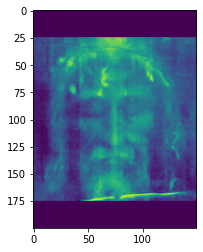

In [11]:
import numpy as np
from PIL import Image, ImageOps

from PIL import Image
img = Image.open( "/content/shroud_face.png" ).convert('L')
import matplotlib.pyplot as plt

img = resizeImage(img, (150,200), padding=True)
# plt.imshow(img)    


plt.imshow(img)  

result = np.array([(0, y, 0) for y in range(0, 10)])
print(result)



In [18]:
import numpy as np
from mpl_toolkits import mplot3d
from matplotlib import pyplot
from stl import mesh




createLamp(["/content/shroud_face.png","/content/shroud_positive_back.png","/content/shroud_positive_front.png","/content/shroud_negative_front.png","/content/shroud_negative_back.png"],"lithopane_jesus_shroud.stl", lampWidth=100, lampHeight=190 )    


(471, 471)
adding padding to img=<PIL.Image.Image image mode=L size=471x471 at 0x7F7D7CD9DDD8>
471 471
DepthArray shape:(471, 471)
471
MAXZ:1.1511680043723663e-14
MINZ:-3.0
(471, 951)
adding padding to img=<PIL.Image.Image image mode=L size=471x928 at 0x7F7D9EC6AE10>
DepthArray shape:(951, 471)
AB=3.7202150475476548 AC=3.0 BC=2.2
Width: 3.0,delta_x:0.3
Rotated Point:(1.3010000599805382, -1.7740909908825524)
Rotated Point:(1.7848430574939615, -1.419272792706042)
Rotated Point:(2.026764556250673, -1.2418636936177867)
Rotated Point:(2.268686055007385, -1.0644545945295316)
Rotated Point:(2.5106075537640966, -0.8870454954412763)
Rotated Point:(2.752529052520808, -0.7096363963530212)
Rotated Point:(2.99445055127752, -0.5322272972647659)
Rotated Point:(3.2363720500342312, -0.35481819817651084)
Rotated Point:(3.478293548790943, -0.17740909908825575)
Rotated Point:(3.720215047547655, -2.220446049250313e-16)
MAXZ:1.7740910053253174
MINZ:-1.4814814329147339
size:(3.4782937, 190.0, 3.2555723)
951


In [ ]:
import bezier
import numpy as np

nodes1 = np.asfortranarray([
        [0.0, 0.5, 1.0],
        [0.0, 1.0, 0.0],
  ])
curve1 = bezier.Curve(nodes1, degree=2)
curve1.plot(num_pts=250)

s_vals = np.linspace(0.0, 1.0, 10)

points = curve1.evaluate_multi(s_vals)

print(np.stack(points, axis=-1))



In [ ]:
files.download('lithopane.stl')

In [ ]:
mesh = createBevelMesh(3.0, 5.0 ,510, bezierThreshold=3.0)
#mesh.x+=10.0
mesh.save("bevel.stl")

from google.colab import files

files.download('bevel.stl')